Crystal Hariga | MSBA | S'21

# Predicting Digital Marketing Response Using ML

### Importing Packages

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# import mglearn
from sklearn import tree
from sklearn import metrics

# Tree based models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Kernel ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# For timing: if you are interested 
from time import perf_counter

# Usual cross-val tools
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline

# Grid searching stuff
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

def MCtraintest(nmc,X,y,modelObj,testFrac):
    # Create memory space for monte-carlo runs
    trainScore = np.zeros(nmc)
    testScore  = np.zeros(nmc)
    for i in range(nmc):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testFrac)
        modelObj.fit(X_train,y_train)
        trainScore[i] = modelObj.score(X_train,y_train)
        testScore[i]  = modelObj.score(X_test,y_test)
    return trainScore,testScore

def scatter2Type(X1,X2,y):
    plt.plot(X1[y==0.],X2[y==0.],'o',label="class 0")
    plt.plot(X1[y==1.],X2[y==1.],'^',label="class 1")
    plt.legend()
    plt.grid()

## Data Preprocessing
### Data Background

This data is taken from a digital marketing campaign on food products which was found on Kaggle through this link: 
[https://www.kaggle.com/jackdaoud/marketing-data]


### Data Cleaning

In [22]:
marketdata = pd.read_csv("marketing_data.csv")
marketdata.isnull()
df = marketdata.dropna()
df.info()
df.isnull().sum()
# Removed the null values 
# From 2240 to 2216 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2216 non-null   int64 
 1   Year_Birth           2216 non-null   int64 
 2   Education            2216 non-null   object
 3   Marital_Status       2216 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2216 non-null   int64 
 6   Teenhome             2216 non-null   int64 
 7   Dt_Customer          2216 non-null   object
 8   Recency              2216 non-null   int64 
 9   MntWines             2216 non-null   int64 
 10  MntFruits            2216 non-null   int64 
 11  MntMeatProducts      2216 non-null   int64 
 12  MntFishProducts      2216 non-null   int64 
 13  MntSweetProducts     2216 non-null   int64 
 14  MntGoldProds         2216 non-null   int64 
 15  NumDealsPurchases    2216 non-null   int64 
 16  NumWeb

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
 Income                0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Response               0
Complain               0
Country                0
dtype: int64

### Data Dictionary

#### Customer Profiles
 - Complain: 1 if customer complained in the last 2 years
 - DtCustomer: date of customer's enrollment with the company
 - Education: customer's level of education
 - Marital: customer's marital status
 - Kidhome: number of small children in customer's household
 - Teenhome: number of teenages in customer's household
 - Income: customer's yearly household income

#### Product preferences
 - MntFishProducts: amount spent on fish products in the last 2 years
 - MntMeatProducts: amount spent on meat products in the last 2 years
 - MntFruits: amount spent on fruits in the last 2 years
 - MntSweetProducts: amount spent on sweet products in the last 2 years
 - MntWines: amount spent on wines in the last 2 years
 - MntGoldProds: amount spent on gold products in the last 2 years


#### Campaign Successes/Failures
 - AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
 - AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
 - AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
 - AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
 - AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
 - **Response**: 1 if customer accepted the offer in the last campaign, 0 otherwise
 

#### Channel Performance
 - NumDealsPurchases: number of purchases made with discount
 - NumCatalogPurchases: number of purchases made with catalog
 - NumStorePurchases: number of purchases made directly in stores
 - NumWebPurchases: number of purchases made through company's website
 - NumWebVisitsMonth: number of visits to company's website in the last month
 - Recency: number of days since the last purchase


## Analysis Scope

Using the Question: `How can we use consumer behavior data to predict a customer's response to a digital marketing campaign on food products?`

I will be focusing on predicting whether the customer will accept the offer from the last campaign (__Response__ variable) based on other variables under different areas.

In [3]:
# Assigning X and Y variables
# Pick 13 predictors
x = df.filter(['Complain', 'MntFishProducts', 'MntMeatProducts',
              'MntFruits', 'MntSweetProducts', 'MntWines',
              'NumDealsPurchases', 'NumStorePurchases', 'NumWebPurchases',
              'NumCatalogPurchases', 'NumWebVisitsMonth', 'Recency', 'MntGoldProds'], axis = 1)
y = df['Response']
print(x.shape)
x.head()

(2216, 13)


,Complain,MntFishProducts,MntMeatProducts,MntFruits,MntSweetProducts,MntWines,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,Recency,MntGoldProds
0,0,111,379,104,189,189,1,6,4,4,1,0,218
1,0,7,64,5,0,464,1,7,7,3,5,0,37
2,0,15,59,11,2,134,1,5,3,2,2,0,30
3,0,0,1,0,0,10,1,2,1,0,7,0,0
4,0,11,24,16,0,6,2,2,3,1,7,0,34


In [43]:
x.describe()

,Complain,MntFishProducts,MntMeatProducts,MntFruits,MntSweetProducts,MntWines,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,Recency,MntGoldProds
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,0.009477,37.637635,166.995939,26.356047,27.028881,305.091606,2.323556,5.800993,4.085289,2.671029,5.319043,49.012635,43.965253
std,0.096907,54.752082,224.283273,39.793917,41.072046,337.327920,1.923716,3.250785,2.740951,2.926734,2.425359,28.948352,51.815414
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,16.000000,2.000000,1.000000,24.000000,1.000000,3.000000,2.000000,0.000000,3.000000,24.000000,9.000000
50%,0.000000,12.000000,68.000000,8.000000,8.000000,174.500000,2.000000,5.000000,4.000000,2.000000,6.000000,49.000000,24.500000
75%,0.000000,50.000000,232.250000,33.000000,33.000000,505.000000,3.000000,8.000000,6.000000,4.000000,7.000000,74.000000,56.000000
max,1.000000,259.000000,1725.000000,199.000000,262.000000,1493.000000,15.000000,13.000000,27.000000,28.000000,20.000000,99.000000,321.000000


## ML Model Evaluation
I will be testing various ML models to find the most accurate to be used in predicting the digital marketing campaign outcome.
Models that will be tested:
* Linear Regression
* Lasso Regression + grid search for parameters
* Logistic Regression
* SVC
* Non-linear SVC (kernel ridge)
* Pipeline with SVC and scaler + grid search for hyperparameters

In [51]:
# REGULAR LINEAR REGRESSION
lin = LinearRegression()
nmc = 500
trainScore, testScore = MCtraintest(nmc,x,y,lin,0.25)

print("Performance:")
print(np.mean(trainScore))
print(np.mean(testScore))

Performance:
0.17465960401041553
0.15019745902681206


Linear Regression doesn't seem to generate good results.

In [53]:
# LASSO REGRESSION
lasso = Lasso(alpha = 0.00001)
nmc = 500
trainScore, testScore = MCtraintest(nmc,x,y,lasso,0.25)

print("Performance:")
print(np.mean(trainScore))
print(np.mean(testScore))

Performance:
0.17413366100759384
0.15168599528897578


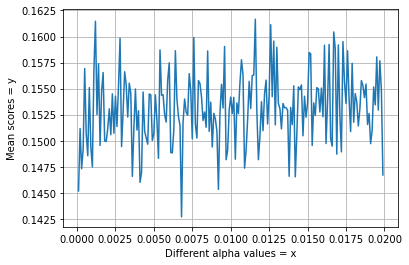

In [57]:
# GRID SEARCH FOR LASSO REGRESSION
alphas = np.arange(start=0.0001,stop=0.0200,step=0.0001)
mean_testscores = []

for i in alphas:
    lasso = Lasso(alpha=i)
    trainscore,testscore = MCtraintest(100,x,y,lasso,0.25)
    mean_testscores.append(np.mean(testscore))
        
# Plot
plt.plot(alphas,mean_testscores)
plt.xlabel("Different alpha values = x")
plt.ylabel("Mean scores = y")
plt.grid()


These results don't seem to be conclusive, which indicates that Lasso is probably not the best model either.

In [60]:
# LOGISTIC REGRESSION
lr = LogisticRegression(multi_class="ovr",solver="sag", C=10)
lr.fit(x, y)
print(lr.score(x, y))

0.8542418772563177


C:\Users\Crystal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Logistic Regression may not be the best model either since the coefficients did not entirely converge.

In [5]:
# SVC
svm = SVC(kernel="rbf", C=10)
trainscore, testscore = MCtraintest(100,x,y,svm,0.25)
print("C = 10")
print("Train Score: ", np.mean(trainscore))
print("Test Score: ", np.mean(testscore))

C = 10
Train Score:  0.8664801444043322
Test Score:  0.8531046931407942


This Support Vector Machine fits the data so much better compared to the other previous models.

In [69]:
# NON-LINEAR SVC
kridge = KernelRidge(alpha=1.,kernel='rbf',gamma=1.0)
trainScore, testScore = MCtraintest(100,x,y,kridge,0.5)
print(np.mean(trainScore))
print(np.mean(testScore))

0.7043687508877742
-0.1264558822449747


In [70]:
# NON-LINEAR SVC WITH SCALER
scaler = StandardScaler()
xs = scaler.fit_transform(x)
kridge = KernelRidge(alpha=1.,kernel='rbf',gamma=1.0)
trainScore, testScore = MCtraintest(100,xs,y,kridge,0.5)
print(np.mean(trainScore))
print(np.mean(testScore))

0.6686167515771991
-0.026284103228644762


In [73]:
# PIPELINE FOR SVC & SCALER

Model = Pipeline([
    ("scaler", StandardScaler()),
    ("nonlinsv", SVC(kernel="rbf",C=1.0,gamma=1.0))
])
trainScore, testScore = MCtraintest(100,x,y,Model,0.5)
print(np.mean(trainScore))
print(np.mean(testScore))

0.9662996389891694
0.8594675090252706


The Pipeline made the scaling work so much better with the SVC compared to with just kernel ridge. But there seems to be overfitting, so it's better to do a grid search for the best hyperparameters.

In [77]:
# GRID SEARCH FOR PIPELINE

param_grid={'nonlinsv__kernel':['rbf'], 'nonlinsv__C':[3, 4, 5, 7, 9, 10, 15],'nonlinsv__gamma':[0.0001,0.1,0.5,1.0,1.5, 2.0, 5]}
score_used = 'r2'
shuffle_split = ShuffleSplit(test_size=0.5, n_splits=100)
grid_search=GridSearchCV(Model,param_grid,cv=shuffle_split,scoring=score_used, 
                          return_train_score=True,n_jobs=1)
grid_search.fit(x,y)
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_nonlinsv__C','param_nonlinsv__gamma']])


    rank_test_score  mean_test_score param_nonlinsv__C param_nonlinsv__gamma
0                39        -0.174945                 3                0.0001
1                 3        -0.123170                 3                   0.1
2                 1        -0.108409                 3                   0.5
3                 4        -0.123685                 3                     1
4                 5        -0.124676                 3                   1.5
5                 7        -0.132284                 3                     2
6                16        -0.145814                 3                     5
7                39        -0.174945                 4                0.0001
8                 8        -0.133731                 4                   0.1
9                 2        -0.118627                 4                   0.5
10               10        -0.138890                 4                     1
11                9        -0.135572                 4                   1.5

I tried to do a grid search to find the best hyperparameters, but it turns out to become worse. All in all, the **regular SVC with kernel rbf without scaling** performed the best, implying that scaling could have made the model more complex, thus leading to overfitting.
## Prediction

Now that we have determined the best model, it is time to actually test this model to predict whether the x variables can predict whether a consumer would respond to the campaign or not. To do this, I am rerunning the SVC model on the dataset that has been split to predict y.

In [6]:
## Splitting the training set with the test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1) #70% train, 30% test
## svm = SVC(kernel="rbf", C=10) -- as taken from previous section

## Training the model on the new training set (70% of data)
svm.fit(X_train, y_train) 

## Checking the results of predicting y using X_test
y_pred = svm.predict(X_test)

## Again, evaluating this y_pred variable with y_test
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.849624060150376


#### So, how could we use this model?

Well, we can try to input our own X values and try to predict a consumer's response.

Reminding what the x labels contain:
- Complain: 1 if customer complained in the last 2 years
- MntFishProducts: amount spent on fish products in the last 2 years
- MntMeatProducts: amount spent on meat products in the last 2 years
- MntFruits: amount spent on fruits in the last 2 years
- MntSweetProducts: amount spent on sweet products in the last 2 years
- MntWines: amount spent on wines in the last 2 years
- MntGoldProds: amount spent on gold products in the last 2 years
- NumDealsPurchases: number of purchases made with discount
- NumCatalogPurchases: number of purchases made with catalog
- NumStorePurchases: number of purchases made directly in stores
- NumWebPurchases: number of purchases made through company's website
- NumWebVisitsMonth: number of visits to company's website in the last month
- Recency: number of days since the last purchase

Well, let's try to use an example:

<div class="alert alert-block alert-info">
<b>Casey</b> is in her late 20s, a casual grocery shopper, prefers to order online, and has a little bit of a sweet tooth.
</div>

Using Casey's profile, we can figure out what her x values would be so that we can predict her response to the digital marketing campaign.

Let's further break down the profile:
1. ... in her late 20s:
    * Based on this information, we can get a sense of the basic demographic information of Casey through this process:

In [33]:
## Filter out customer data to reflect "late 20s"
# Create a new column reflecting age
pd.options.mode.chained_assignment = None # Remove SettingWithCopyWarning
df["current_age"] = 2021 - df["Year_Birth"]
late20s = df[df["current_age"].between(27, 29)]

## Show mean data for demographics information
late20s.describe()
#late20s.head()

## Can imply that an average female in her late 20s have 0 children at home, tend to live 


,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,current_age
count,21.000000,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0,21.000000
mean,5384.000000,1992.523810,0.190476,0.0,45.761905,343.904762,46.476190,341.428571,76.761905,39.142857,...,5.904762,4.095238,0.095238,0.047619,0.142857,0.190476,0.047619,0.190476,0.0,28.476190
std,3061.024894,0.749603,0.402374,0.0,26.277185,299.264750,56.087092,296.769872,78.926488,40.986932,...,2.755082,2.662795,0.300793,0.218218,0.358569,0.402374,0.218218,0.402374,0.0,0.749603
min,821.000000,1992.000000,0.000000,0.0,7.000000,1.000000,0.000000,3.000000,3.000000,1.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,27.000000
25%,3005.000000,1992.000000,0.000000,0.0,13.000000,34.000000,4.000000,66.000000,8.000000,10.000000,...,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,28.000000
50%,4654.000000,1992.000000,0.000000,0.0,55.000000,351.000000,25.000000,335.000000,52.000000,26.000000,...,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,29.000000
75%,7734.000000,1993.000000,0.000000,0.0,66.000000,471.000000,61.000000,565.000000,93.000000,61.000000,...,7.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,29.000000
max,10619.000000,1994.000000,1.000000,0.0,94.000000,966.000000,169.000000,921.000000,250.000000,169.000000,...,12.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,29.000000


   * Can imply that an average female in her late 20s would have at least have graduated from higher education, be together with a partner, no children at home, have an income of roughly around $60K. 

2. ... casual grocery shopper, prefers to order online:
    * Moving away from the demographics, we delve a little bit into her shopping habits. Based on this piece of information, we can imply that the frequency Casey shops will be mid-low, and that majority of her purchases would be online.
        * Complain: less so, since it's not in-person
        * NumWebPurchases > NumCatalogPurchases or NumStorePurchases
        * NumWebVisitsMonth would be mid-high as well
        * Recency would be average

3. ... has a little bit of a sweet tooth:
    * Additional information implies that the amount Casey spends on sweets would be more than average.
        * MntSweetProducts would be quite high
        
        
#### Summary
To summarize, the above profile information can determine the values of X we'd like to provide as input to the ML model.

* 'Complain': 0, since she prefers to order online, so there's a lesser chance for her to complain
* 'MntFishProducts': 70, based on average data
* 'MntMeatProducts': 330, a little lower than average data to add to sweet products
* 'MntFruits': 46
* 'MntSweetProducts': 80, higher than average
* 'MntWines': 340, about average
* 'NumDealsPurchases': 2, since Casey is a casual shopper
* 'NumStorePurchases': 2, reflecting the deals used
* 'NumWebPurchases': 5, we can assume that Casey spends roughly 200% more purchases on the Web
* 'NumCatalogPurchases': 0, since we can assume that Casey would most likely be surfing on the internet instead of using a catalog
* 'NumWebVisitsMonth': 3, since she's a casual grocery shopper
* 'Recency': 10, based on the fact that she's a casual shopper
* 'MntGoldProds': 300, assuming that she is quite the average person

Now it's time to test the model!

In [35]:
casey = [[0, 70, 330, 46, 80, 340, 2, 2, 5, 0, 3, 10, 300]] ## inputting the numbers from the summary into Casey's row
y_pred = svm.predict(casey)
print(y_pred)

[0]


Based on the information above, the ML model predicts that Casey would not accept the offer from the digital marketing campaign provided.

Although the focus of this project is to predict a potential consumer's response based on a ML model, we can further delve to figure out what exactly are important factors that determine an individual's response to the digital marketing campaign provided. To continue this project, we could conduct a regression of response on all the variables and find out which ones are significant before including that in the ML model.

This marks the end of this project. **Thank you for checking this out!**